In [2]:
!pip install seaborn

     |████████████████████████████████| 283 kB 12.9 MB/s eta 0:00:01


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
dfx = pd.read_csv(
  "FF.csv",
  parse_dates=[0],
  index_col= 0,
  header = None
)


In [6]:
df = dfx.iloc[-50000:] 

In [4]:
len(df)

50000

In [7]:
cols = ['lat','long','max_temp','sun_hour','dew_point','heat_index','cloud_cover','humid','precp','wind_speed','fire_or_not','elevation']
df.columns = cols
df.head()

,lat,long,max_temp,sun_hour,dew_point,heat_index,cloud_cover,humid,precp,wind_speed,fire_or_not,elevation
0,,,,,,,,,,,,
2019-03-28,25.22499,77.15281,36.0,11.6,2.0,30.0,6.0,15.0,0.0,8.0,0.0,436
2019-03-29,25.22499,77.15281,39.0,11.6,1.0,32.0,2.0,14.0,0.0,9.0,0.0,436
2019-03-30,25.22499,77.15281,40.0,11.6,1.0,34.0,23.0,12.0,0.3,8.0,0.0,436
2019-03-31,25.22499,77.15281,37.0,11.6,6.0,30.0,3.0,20.0,0.0,13.0,0.0,436
2019-04-01,25.22499,77.15281,36.0,11.6,-4.0,30.0,0.0,10.0,0.0,10.0,1.0,436


In [8]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

40000 10000


In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [63]:
from sklearn.preprocessing import RobustScaler

f_columns = ['max_temp','sun_hour','dew_point','heat_index','cloud_cover','humid','precp','wind_speed','elevation']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['lat']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['lat'] = cnt_transformer.transform(train[['lat']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['lat'] = cnt_transformer.transform(test[['lat']])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [64]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.lat, time_steps)
X_test, y_test = create_dataset(test, test.lat, time_steps)


In [12]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=72, 
    validation_split=0.1,
    shuffle=False
)

Train on 35991 samples, validate on 3999 samples
Epoch 1/50
35991/35991 [==============================] - 10s 283us/sample - loss: 0.2711 - val_loss: 1.3080
Epoch 2/50
35991/35991 [==============================] - 6s 171us/sample - loss: 0.2486 - val_loss: 1.2775
Epoch 3/50
35991/35991 [==============================] - 6s 174us/sample - loss: 0.2360 - val_loss: 1.2843
Epoch 4/50
35991/35991 [==============================] - 6s 170us/sample - loss: 0.2254 - val_loss: 1.2389
Epoch 5/50
35991/35991 [==============================] - 6s 167us/sample - loss: 0.2227 - val_loss: 1.2060
Epoch 6/50
35991/35991 [==============================] - 6s 168us/sample - loss: 0.2158 - val_loss: 1.1819
Epoch 7/50
35991/35991 [==============================] - 6s 167us/sample - loss: 0.2060 - val_loss: 1.0115
Epoch 8/50
35991/35991 [==============================] - 6s 167us/sample - loss: 0.1795 - val_loss: 0.8777
Epoch 9/50
35991/35991 [==============================] - 6s 168us/sample - loss: 0.15

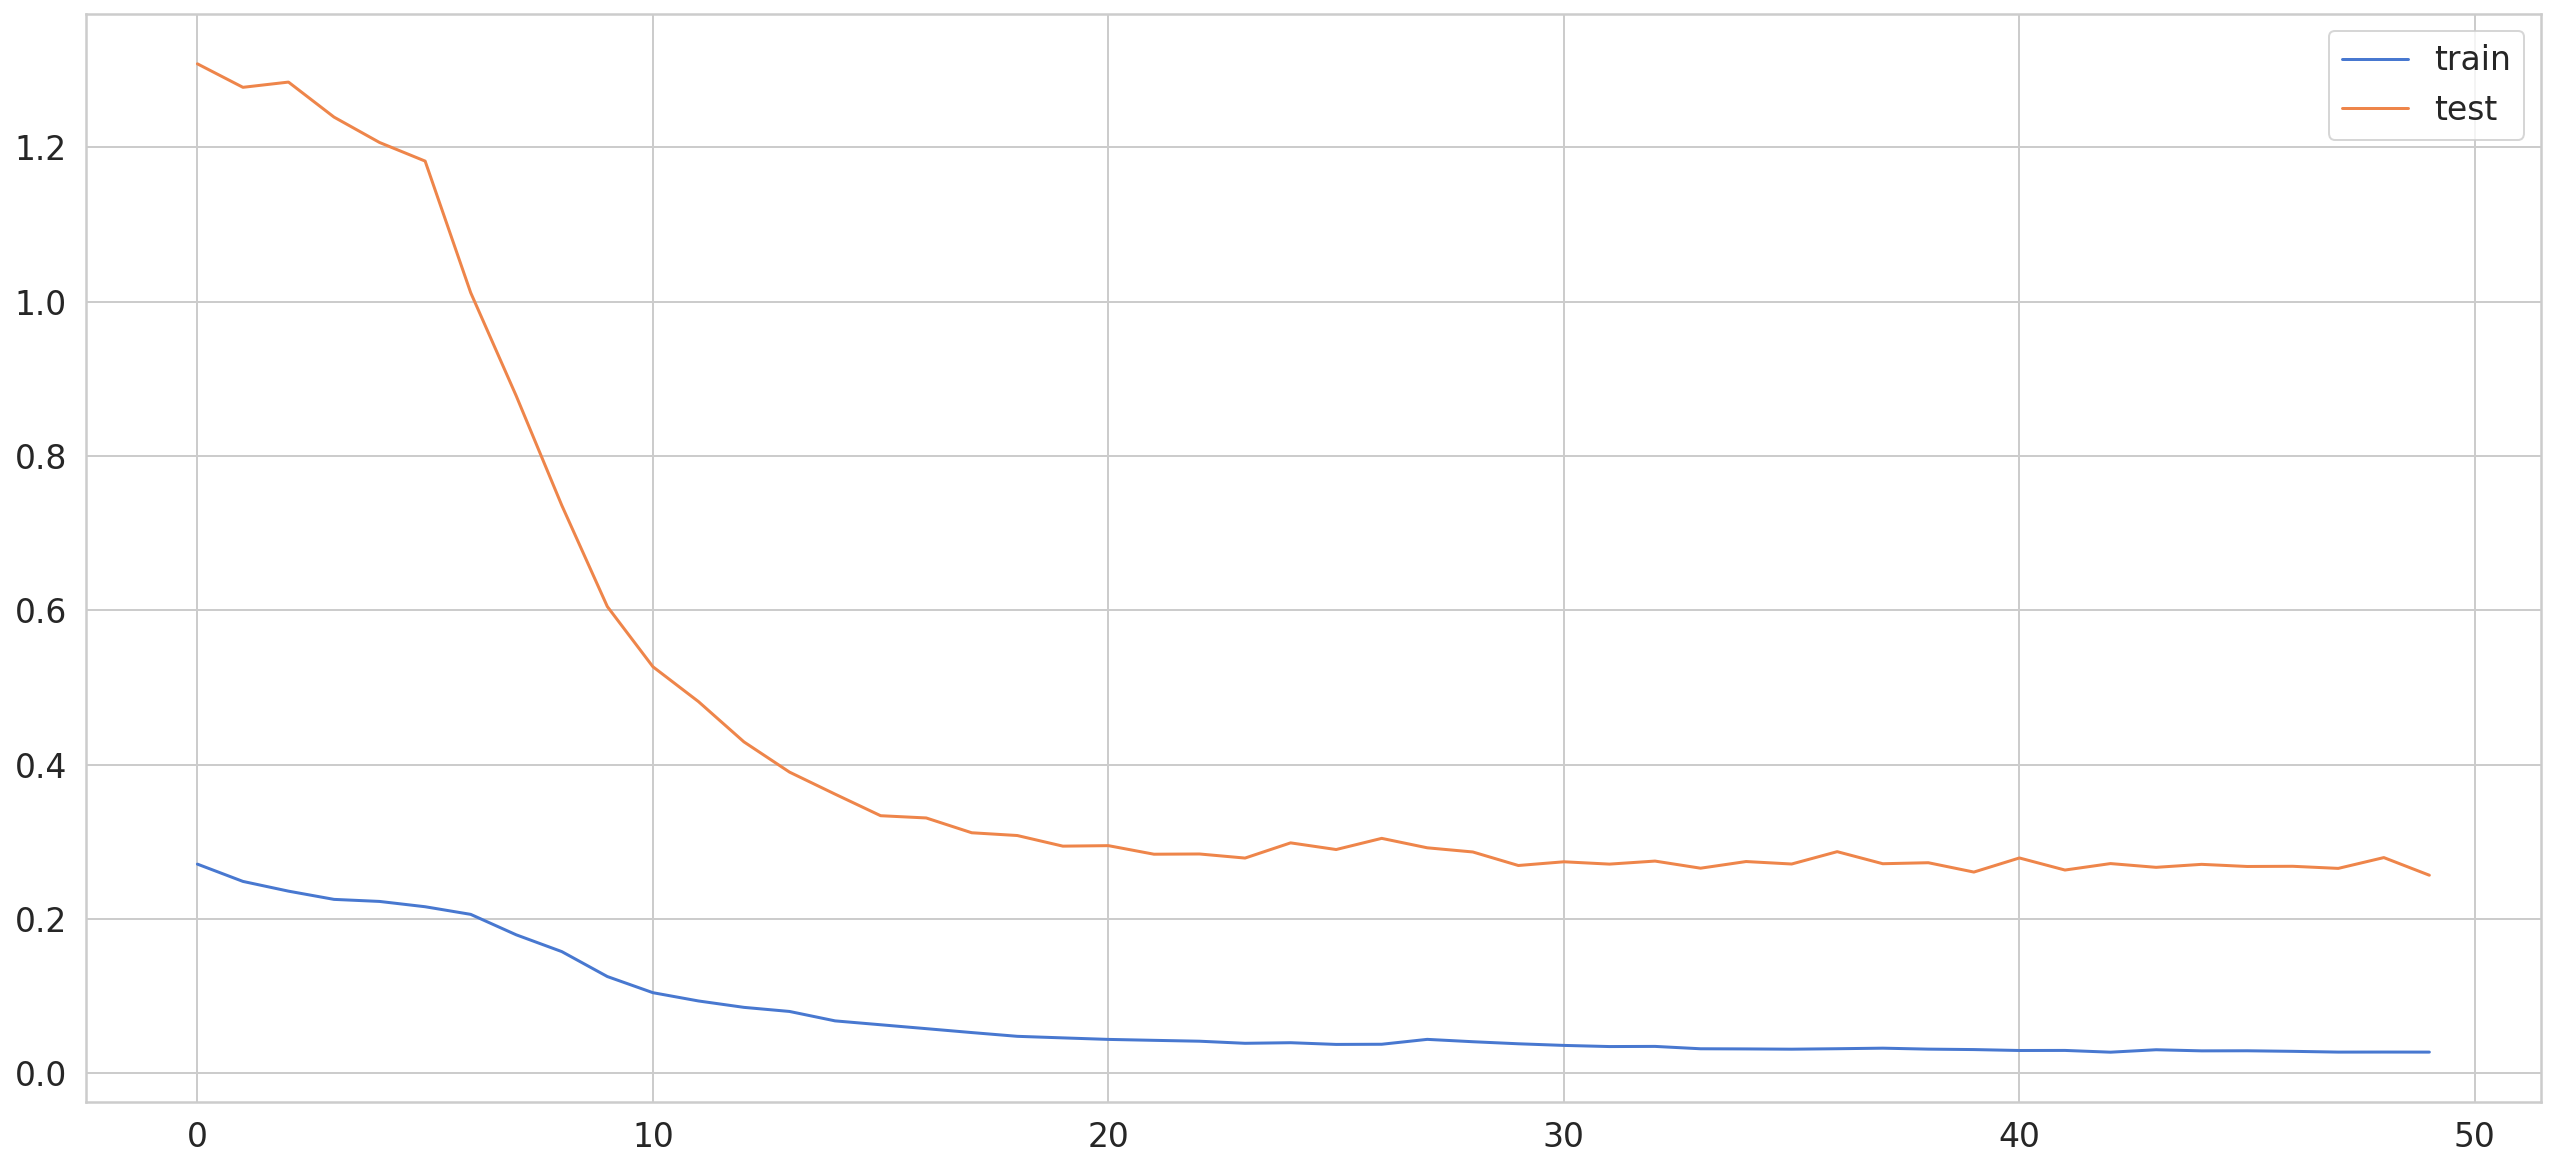

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [35]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_pred, y_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.446


In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  144384    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  257       
Total params: 144,641
Trainable params: 144,641
Non-trainable params: 0
_________________________________________________________________
None


In [16]:

import azureml.core


# Check core SDK version number.
print('SDK version:', azureml.core.VERSION)

SDK version: 1.16.0


In [17]:
from azureml.core import Workspace


ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

AI-For-Earh
Mahesh-Resouce-Group
southeastasia
eec2f4e3-2641-43c4-a108-eaa29422f3cc


In [18]:
ws.write_config(path="./", file_name="ws_config.json")
# View your configuration file
!cat .azureml/ws_config.json

{"Id": null, "Scope": "/subscriptions/eec2f4e3-2641-43c4-a108-eaa29422f3cc/resourceGroups/Mahesh-Resouce-Group/providers/Microsoft.MachineLearningServices/workspaces/AI-For-Earh"}

In [18]:
import os
import h5py
from sklearn import datasets 
 
# save model
# serialize model to JSON
LSTM_MODEL = 'modelLS.h5'

# and store the weights in h5
MODEL_WEIGHTS = 'modellstm.h5'


model_json = model.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_WEIGHTS)
print("Model saved")

Model saved


In [23]:
!pip install h5py

In [23]:
from sklearn.preprocessing import RobustScaler

f_columns = ['max_temp','sun_hour','dew_point','heat_index','cloud_cover','humid','precp','wind_speed','elevation']

f_transformer1 = RobustScaler()
cnt_transformer1 = RobustScaler()

f_transformer1 = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer1 = cnt_transformer.fit(train[['long']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['long'] = cnt_transformer.transform(train[['long']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['long'] = cnt_transformer.transform(test[['long']])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [24]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.long, time_steps)
X_test, y_test = create_dataset(test, test.long, time_steps)

In [25]:
model1 = keras.Sequential()
model1.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model1.add(keras.layers.Dropout(rate=0.2))
model1.add(keras.layers.Dense(units=1))
model1.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
history2 = model1.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=200, 
    validation_split=0.1,
    shuffle=False
)

Train on 35991 samples, validate on 3999 samples
Epoch 1/30
35991/35991 [==============================] - 4s 107us/sample - loss: 0.0073 - val_loss: 0.1565
Epoch 2/30
35991/35991 [==============================] - 4s 108us/sample - loss: 0.0069 - val_loss: 0.1662
Epoch 3/30
35991/35991 [==============================] - 4s 107us/sample - loss: 0.0069 - val_loss: 0.1591
Epoch 4/30
35991/35991 [==============================] - 4s 107us/sample - loss: 0.0065 - val_loss: 0.1671
Epoch 5/30
35991/35991 [==============================] - 4s 110us/sample - loss: 0.0065 - val_loss: 0.1615
Epoch 6/30
35991/35991 [==============================] - 4s 107us/sample - loss: 0.0071 - val_loss: 0.1717
Epoch 7/30
35991/35991 [==============================] - 4s 108us/sample - loss: 0.0068 - val_loss: 0.1545
Epoch 8/30
35991/35991 [==============================] - 4s 109us/sample - loss: 0.0068 - val_loss: 0.1577
Epoch 9/30
35991/35991 [==============================] - 4s 108us/sample - loss: 0.006

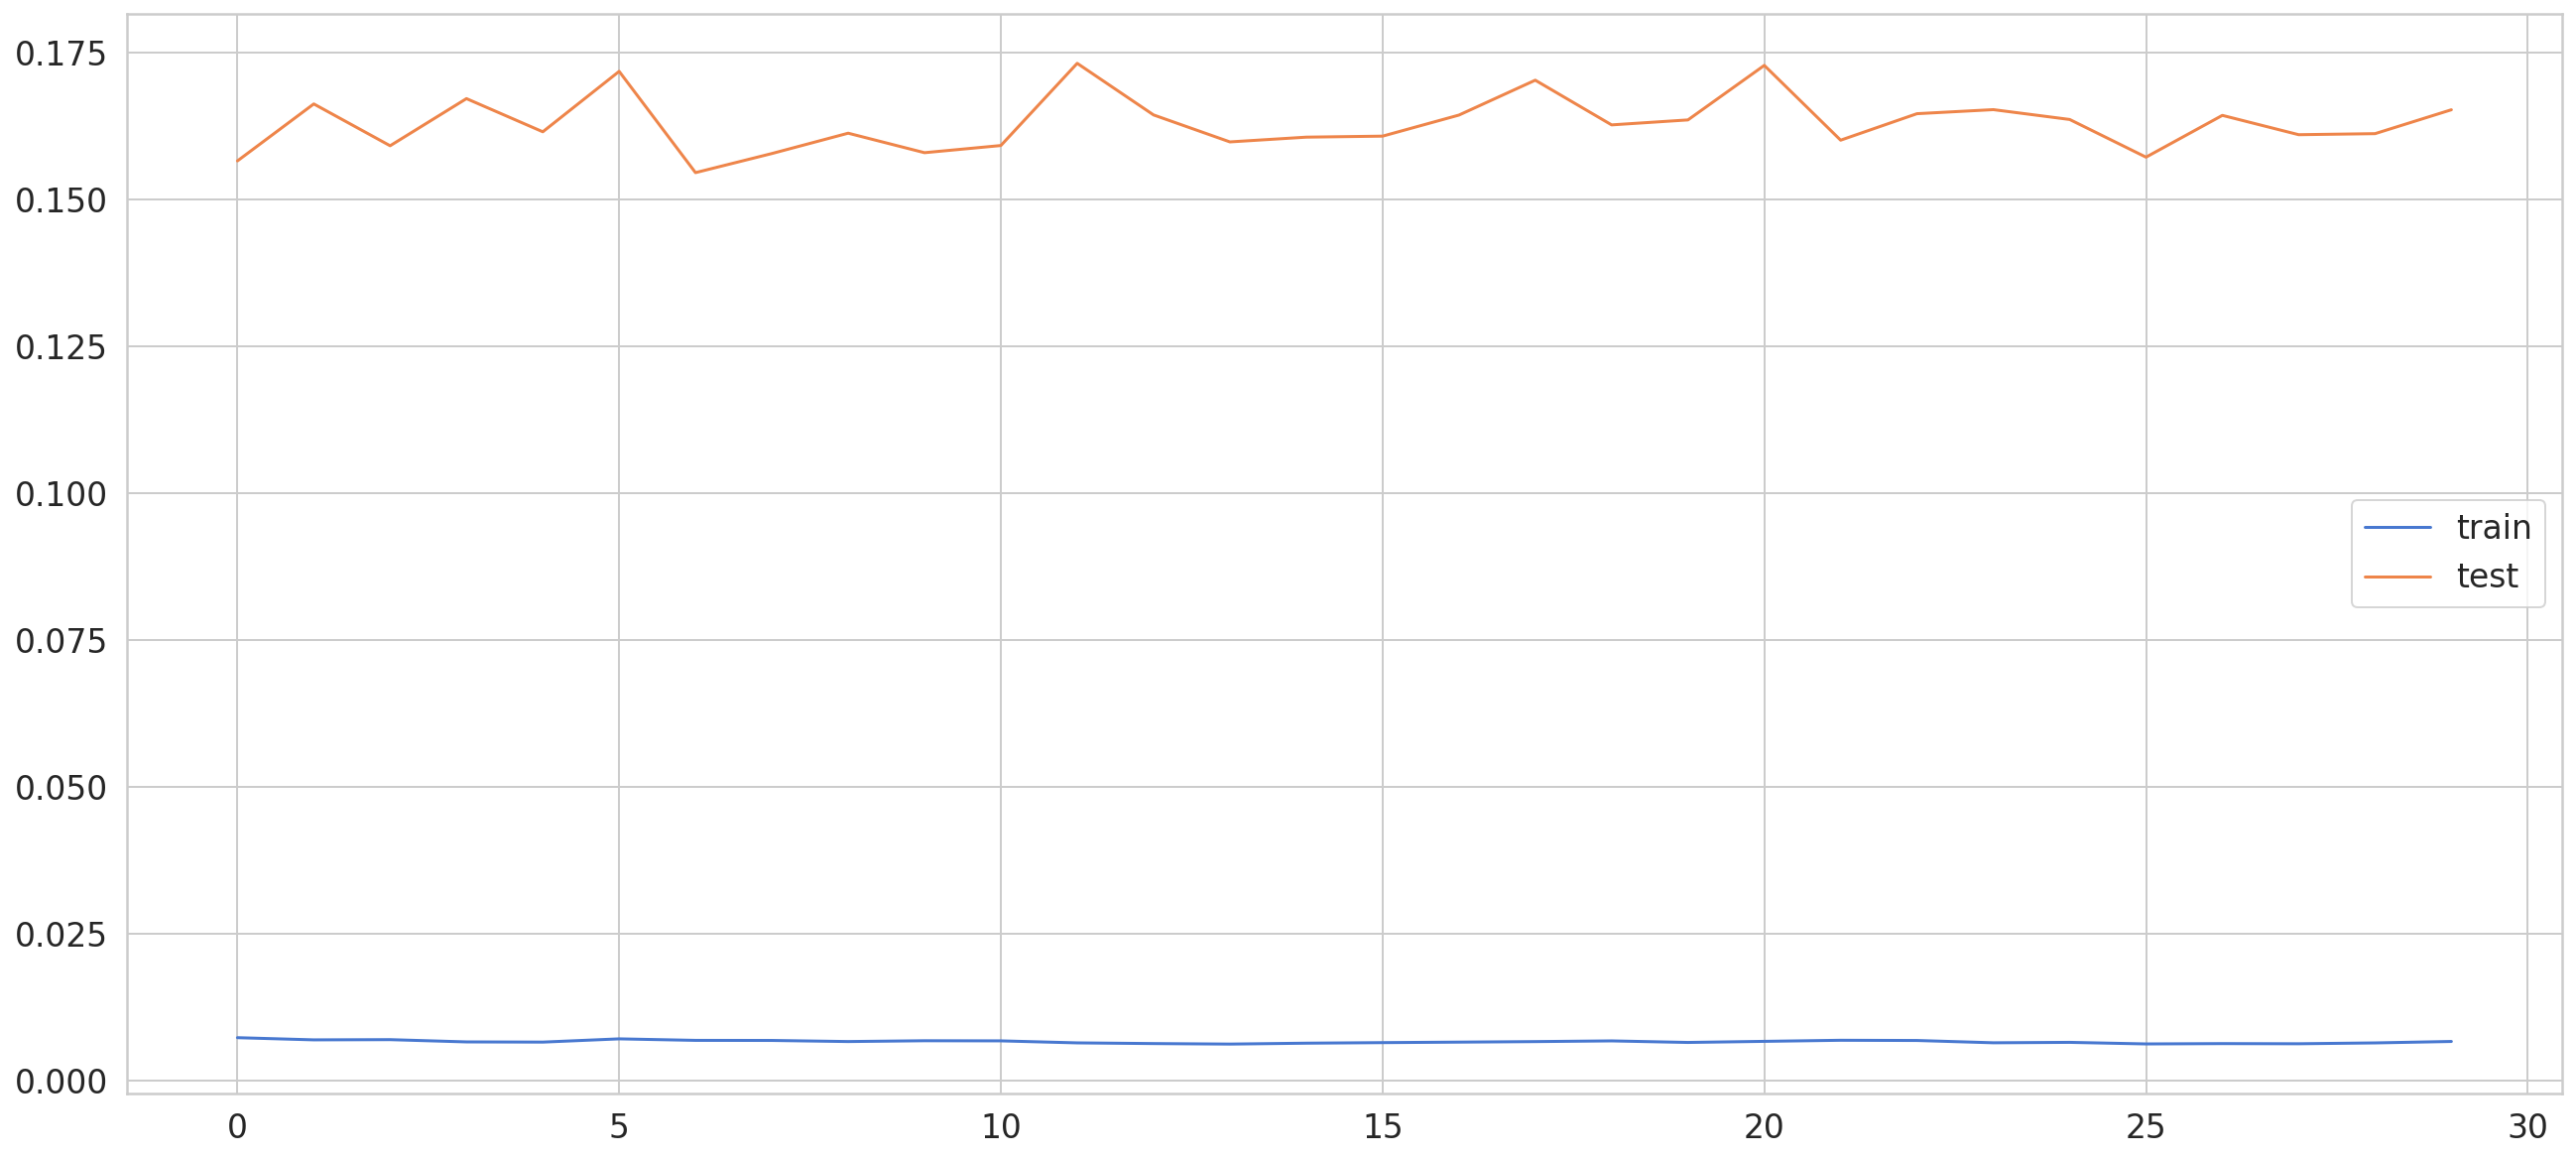

In [59]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend();

In [86]:
y_pred1 = model1.predict(X_test)

In [87]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred1)

In [88]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_pred, y_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.357


In [60]:
import os
import h5py
from sklearn import datasets 
 
# save model
# serialize model to JSON
LSTM_MODEL = 'modelLong.json'

# and store the weights in h5
MODEL_WEIGHTS = 'modellong.h5'


model_json = model1.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights(MODEL_WEIGHTS)
print("Model saved")

Model saved


In [61]:
model.save('LSTMTest.h5')

In [79]:
df1 = pd.read_csv(
  "FF.csv",
  parse_dates=[0],
  index_col= 0,
  header = None
)

In [84]:
df1.head()

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
2018-04-15,38.0,12.8,14.0,33.0,13.0,31.0,0.4,11.0,0.0,264
2018-04-15,38.0,12.8,14.0,33.0,13.0,31.0,0.4,11.0,0.0,264
2018-04-16,40.0,12.8,13.0,35.0,5.0,28.0,0.0,7.0,0.0,264
2018-04-16,40.0,12.8,13.0,35.0,5.0,28.0,0.0,7.0,0.0,264
2018-04-17,42.0,12.8,8.0,37.0,3.0,18.0,0.0,9.0,0.0,264


In [81]:
df1 = df1.drop([1,2], axis = 1)

In [85]:
df1.to_csv('dep.csv')